In [64]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from claspy.segmentation import BinaryClaSPSegmentation
import pickle
import ruptures as rpt
from fastdtw import fastdtw

import statistics

from tqdm import tqdm

import os

In [2]:
def find_most_similar_segment(x, y):
    x_array = np.array([x])
    best_segment = []
    best_similarity = -1  # Initialize with a low value
    best_idx = 0 # index of the best segment start

    for i in range(len(y) - len(x) + 1):
        segment = y[i:i+len(x)]
        segment_array = np.array([segment])

        # Calculate the cosine similarity between x and the current segment
        similarity = cosine_similarity(x_array, segment_array)[0][0]

        # Update the best segment if the current similarity is higher
        if similarity > best_similarity:
            best_segment = segment
            best_similarity = similarity
            best_idx = i

    return best_segment, best_idx, best_similarity

In [3]:
def find_segment_dtw(query, reference):
    query_segment = np.array(query)
    long_time_series = np.array(reference)

    # Initialize variables to store the best match
    best_distance = float('inf')
    best_start_index = None

    # Iterate through all possible subsegments of the longer time series
    for i in range(len(long_time_series) - len(query_segment) + 1):
        subsegment = long_time_series[i:i+len(query_segment)]
        distance, _ = fastdtw(query_segment, subsegment)

        # Check if this subsegment is the best match so far
        if distance < best_distance:
            best_distance = distance
            best_start_index = i

    # Extract the most similar segment
    most_similar_segment = long_time_series[best_start_index:best_start_index+len(query_segment)]

    return most_similar_segment, best_start_index


In [4]:
def find_dtw_slide(query, reference):

  # Define your time series data
  x = np.array(query, dtype=float)
  y = np.array(reference, dtype=float)

  # Set initial best match and distance
  best_match = None
  best_distance = float('inf')

  # Define a range of subsegment lengths to search
  min_subsegment_length = len(x) - 2
  max_subsegment_length = len(x) + 2

  for subsegment_length in range(min_subsegment_length, max_subsegment_length + 1):
      for i in range(len(y) - subsegment_length + 1):
          subsegment = y[i:i+subsegment_length]
          distance, _ = fastdtw(x, subsegment)

          if distance < best_distance:
              best_distance = distance
              best_match = subsegment

  # Print the most similar subsegment
  return(best_match)


In [97]:
def find_dtw_greedy(query, reference):

  # Define your time series data
  x = np.array(query, dtype=float)
  y = np.array(reference, dtype=float)

  # Set initial best match and distance
  best_match = None
  best_distance = float('inf')
  start_id = int()
  end_id = int()

  # Define the initial subsegment length
  subsegment_length = len(x)

  for i in range(len(y) - subsegment_length + 1):
      subsegment = y[i:i+subsegment_length]
      distance, _ = fastdtw(x, subsegment)

      if distance < best_distance:
          best_distance = distance
          best_match = subsegment
          start_id = i
          end_id = i+subsegment_length

  # Calculate DTW distance for the initial subsegment length
  distance, _ = fastdtw(x, y[start_id:end_id])

  while True:
      # Check the next longer subsegment to the right one by one
      if subsegment_length < len(y):
          end_id += 1
          extended_subsegment = y[start_id:end_id]
          extended_distance, _ = fastdtw(x, extended_subsegment)

          if extended_distance < distance:
              distance = extended_distance
          else:
              # If increasing the length doesn't improve the distance, break the loop
              end_id -= 1
              break

  while start_id > 0:
      # Check the next longer subsegment to the left one by one
      if start_id > 0:
          start_id -= 1
          extended_subsegment = y[start_id:end_id]
          extended_distance, _ = fastdtw(x, extended_subsegment)

          if extended_distance < distance:
              distance = extended_distance
          else:
              # If increasing the length doesn't improve the distance, break the loop
              start_id += 1
              break

  # Update the best match if a better subsegment is found
  if distance < best_distance:
      best_distance = distance
      best_match = y[start_id:end_id]

  # Return the most similar subsegment
  return best_match, start_id, end_id, best_distance

In [6]:
def fuzz_similar_segment(x, y):
    max_similarity = -1
    best_segment = []
    best_idx = 0

    # Iterate through the reference list `y` to find the most similar segment
    for i in range(len(y) - len(x) + 1):
        segment = y[i:i+len(x)]
        similarity = fuzz.token_set_ratio(x, segment)

        # Update the best segment if the current similarity is higher
        if similarity > max_similarity:
            max_similarity = similarity
            best_segment = segment
            best_idx = i

    return best_segment, best_idx


In [7]:
def reduce_list_avg(original_list, reduction):
    reduced_list = []

    for i in range(0, len(original_list), reduction):
        chunk = original_list[i:i + reduction]
        average = sum(chunk) / len(chunk)
        reduced_list.append(average)

    return reduced_list


In [65]:
def reduce_list_median(original_list, reduction):
    reduced_list = []

    for i in range(0, len(original_list), reduction):
        chunk = original_list[i:i + reduction]
        median = statistics.median(chunk)
        reduced_list.append(median)

    return reduced_list

In [87]:
def split_random(input_list, min_size=20, max_size=100):
    result = []
    remaining_list = input_list[:]
    res_idx = [0]
    last_index = 0
    
    while remaining_list:
        # Randomly select a chunk size between min_size and max_size
        chunk_size = random.randint(min_size, max_size)
        
        # Ensure that the chunk size doesn't exceed the remaining list length
        chunk_size = min(chunk_size, len(remaining_list))
        
        # Take the chunk from the beginning of the remaining list
        chunk = remaining_list[:chunk_size]
        
        # Remove the chunk from the remaining list
        remaining_list = remaining_list[chunk_size:]

        # Calculate index
        index = last_index + chunk_size
        last_index = index
        
        # Append the chunk and the index to the result list
        result.append(chunk)
        res_idx.append(index)
    
    return result, res_idx

In [12]:
keep_idx_path = 'data/keep_idx.txt'

# Initialize an empty list to store the kept indexes
kept_indexes = []

# Check if the keep_idx.txt file exists
if os.path.exists(keep_idx_path):
    # If it exists, load the existing indexes from the file
    with open(keep_idx_path, 'r') as file:
        lines = file.readlines()
        kept_indexes = [int(line.strip()) for line in lines]

matches = pickle.load(open("data/matches_short.p", "rb"))

matches = [matches[i] for i in kept_indexes]

In [37]:
x = [i.start for i in matches[6][0]]
y = [i.pitch for i in matches[6][0]]

In [38]:
x1 = [i.start for i in matches[6][1]]
y1 = [i.pitch for i in matches[6][1]]

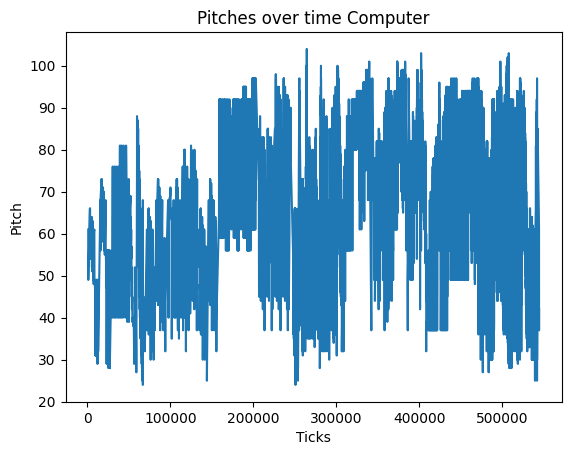

In [39]:
plt.plot(x, y)

# Add labels and title
plt.xlabel("Ticks")
plt.ylabel("Pitch")
plt.title("Pitches over time Computer")

# Show the plot
plt.show()

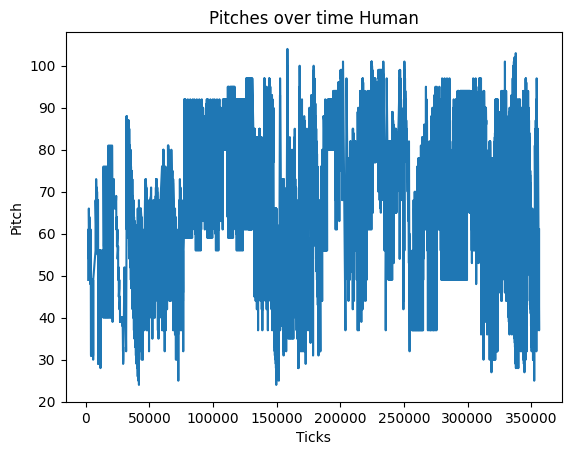

In [40]:
plt.plot(x1, y1)

# Add labels and title
plt.xlabel("Ticks")
plt.ylabel("Pitch")
plt.title("Pitches over time Human")

# Show the plot
plt.show()

In [88]:
min_l = 40
max_l = 100
y_chunk, y_idx = split_random(y, min_l, max_l)
print(y_idx)

[0, 88, 166, 247, 338, 396, 470, 562, 616, 707, 799, 870, 969, 1053, 1124, 1210, 1294, 1377, 1469, 1516, 1572, 1619, 1686, 1778, 1840, 1921, 1998, 2087, 2173, 2264, 2353, 2451, 2542, 2636, 2696, 2789, 2841, 2927, 3022, 3066, 3121, 3199, 3263, 3329, 3397, 3487, 3556, 3628, 3676, 3747, 3807, 3853, 3896, 3940, 3984, 4084, 4152, 4206, 4259, 4353, 4402, 4469, 4557, 4636, 4725, 4799, 4858, 4942, 5016, 5074, 5159, 5244, 5334, 5414, 5514, 5554, 5650, 5750, 5848, 5942, 6033, 6109, 6179, 6264, 6306, 6371, 6419, 6472, 6572, 6612, 6706, 6788, 6871, 6936, 6977, 7023, 7106, 7169, 7247, 7307, 7394, 7475, 7554, 7567]


In [114]:
min_l = 40
max_l = 100
window = max_l*2

def segment_dtw(match):

    # sequences in and out
    bad = match[0]
    good = match[1]

    # Work only with pitches for matching
    y = [i.pitch for i in bad]
    y1 = [i.pitch for i in good]
    
    # Random split into chunks
    in_chunks, in_idx = split_random(y, min_l, max_l)
    
    idx_chunks = []
    distances = []
    
    # Keep track of where we are to ID the matches in the pre-chunked sequence
    start_id = 0
    
    # Go over each chunk and find its match in the 'good' out sequence
    for i, query in enumerate(in_chunks):
        # Keep track of where we are to ID the matches in the pre-chunked sequence
        current_pos = len([item for chunk in in_chunks[:i+1] for item in chunk])
        # Only consider the approximate area around the current chunk
        window_start = (current_pos - window) if current_pos>=window else 0
        window_end = (current_pos + window) if current_pos<=(len(y1)-window) else len(y1)
        
        result, start, end, distance = find_dtw_greedy(query, y1[window_start:window_end])

        # Update start and end in relation to the whole 'good' sequence
        start = window_start + start
        end = window_start + end
        
        # Save the absolute indexes + distance
        idx_chunks.append([[start_id, current_pos], [start, end], distance])

        # Update start id
        start_id = current_pos

    segmented_matches = []
    
    # Use the saved indexes to segment the original data
    # Output is [match_in, match_out, distance]
    for chunk in idx_chunks:
        seg_in = good[chunk[0][0]:chunk[0][1]]
        seg_out = bad[chunk[1][0]:chunk[1][1]]
        dist = chunk[2]
        segmented_matches.append([seg_in, seg_out, dist])
        
    return segmented_matches

In [115]:
%%time
segmented_matches = segment_dtw(matches[0])

CPU times: total: 1min 42s
Wall time: 1min 42s


In [116]:
len(segmented_matches)

72

In [105]:
print(idx_in)

[[0, 96], [96, 150], [150, 230], [230, 291], [291, 361], [361, 426], [426, 501], [501, 559]]


In [106]:
print(idx_out)

[[0, 96], [96, 152], [150, 231], [234, 296], [297, 368], [378, 443], [447, 523], [523, 581]]


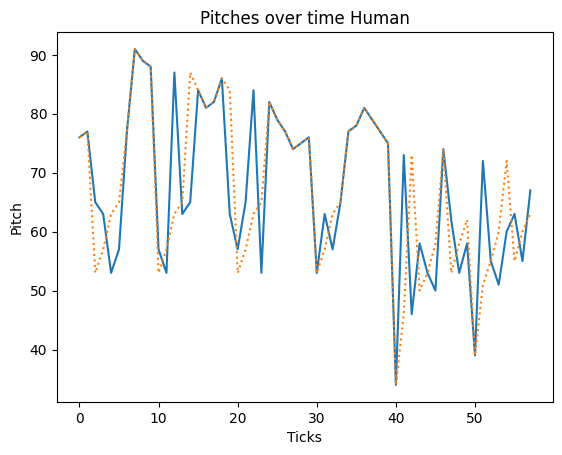

In [108]:
plt.plot(y[idx_in[-1][0]:idx_in[-1][1]])
plt.plot(y1[idx_out[-1][0]:idx_out[-1][1]], ls = 'dotted')

# Add labels and title
plt.xlabel("Ticks")
plt.ylabel("Pitch")
plt.title("Pitches over time Human")

# Show the plot
plt.show()

In [ ]:
%%time
result, start, end = find_dtw_greedy(q_short, s_short)
print("result:", result[0:25], "| start:", start, "| end:", end)

wide_start = (start*10)-20 if (start*10)>20 else 0
wide_end = (end*10)+20 if (end*10)+20<len(y1) else len(y1)
y2 = y1[wide_start:wide_end]
result, start, end = find_dtw_greedy(query, y2)

result: [64.7 65.9 63.  61.2 61.7 58.4 58.8 59.3 52.7 57.7 62.5 64.7 65.9 63.
 61.2 61.7 58.4 58.8 59.1 57.  56.1] | start: 75 | end: 96
CPU times: user 42.5 ms, sys: 0 ns, total: 42.5 ms
Wall time: 47.1 ms


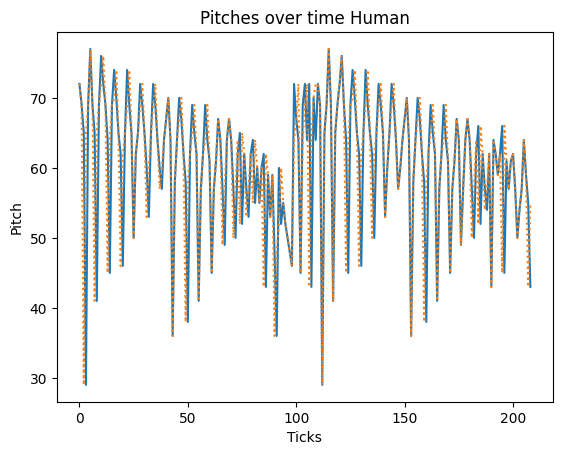

In [ ]:
plt.plot(query)
plt.plot(result, ls = 'dotted')

# Add labels and title
plt.xlabel("Ticks")
plt.ylabel("Pitch")
plt.title("Pitches over time Human")

# Show the plot
plt.show()

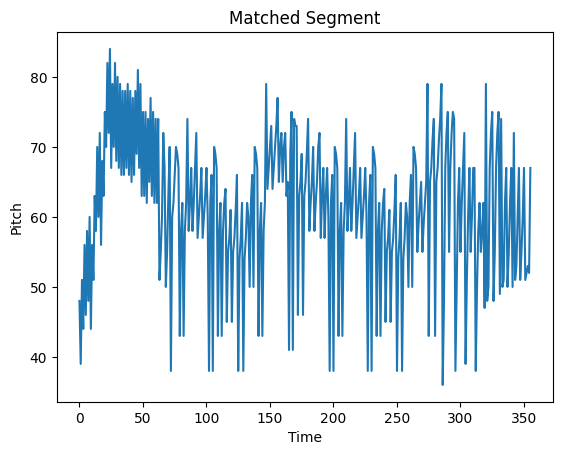

In [ ]:
plt.plot(y_segment[:])
plt.xlabel("Time")
plt.ylabel("Pitch")
plt.title('Matched Segment')
plt.show()

In [ ]:
print(len(y_segment), len(query))

356 350


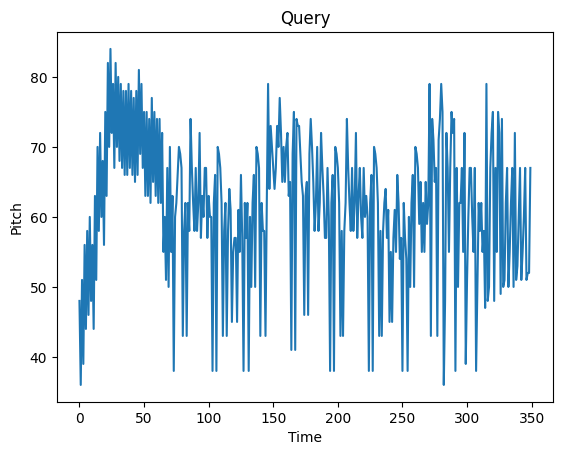

In [ ]:
plt.plot(query)

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Pitch")
plt.title("Query")

# Show the plot
plt.show()

In [ ]:
import numpy as np
from scipy.signal import find_peaks, correlate

x = np.asarray(query)
y = np.asarray(y_segment)

# Assuming x and y are your time series
# First, find the peaks and valleys in both x and y
peaks_x, _ = find_peaks(x)
valleys_x, _ = find_peaks(-x)

peaks_y, _ = find_peaks(y)
valleys_y, _ = find_peaks(-y)

# Calculate cross-correlation between the peaks and valleys of x and y
correlation_peaks = correlate(x, y, mode='full')
correlation_valleys = correlate(-x, -y, mode='full')

# Find the time shift that maximizes the cross-correlation for both peaks and valleys
shift_peaks = np.argmax(correlation_peaks) - (len(x) - 1)
shift_valleys = np.argmax(correlation_valleys) - (len(x) - 1)

# Apply the time shift to y
aligned_y = np.roll(y, shift_peaks)  # Align peaks
aligned_y = np.roll(aligned_y, shift_valleys)  # Align valleys

# Now, aligned_y should be aligned with x


In [ ]:
def segment_and_match(seq_from, seq_to, seq_len=200):

  clasp = BinaryClaSPSegmentation(validation="score_threshold", threshold=.55)

  y = [i[2] for i in seq_from]
  y1 = [i[2] for i in seq_to]

  segments_from = []
  segments_to = []

  result = clasp.fit_predict(np.array(y, dtype=np.float64))
  segment_list = result.tolist()
  segment_list.append(len(y))
  segment_list = [0]+(segment_list)

  max_difference = seq_len

  segment_list_adj = [segment_list[0]]  # Initialize the result list with the first element

  for i in range(1, len(segment_list)):
      if segment_list[i] - segment_list_adj[-1] <= max_difference:
          continue  # Skip this element if the difference is within the limit
      else:
          segment_list_adj.append(segment_list[i])  # Add the element to the result list


  #rpt.display(np.array(y, dtype=np.float64), segment_list_adj)
  #plt.show()

  for i in range(0,len(segment_list_adj)-1):
      query = y[segment_list_adj[i]:segment_list_adj[i+1]]

      q_short = reduce_list_avg(query, 10)
      s_short = reduce_list_avg(y1, 10)
      result, idx, score = find_most_similar_segment(q_short, s_short)

      window_size = 0.1
      tail_srch = 20
      left_window_start = int((idx*10)-(len(query)*window_size))
      right_window_start = int((idx*10)+(len(query)*window_size))
      left_window_end = int((idx*10)+(len(query)*(1-window_size)))
      right_window_end = int((idx*10)+(len(query)*(1+window_size)))
      if left_window_start < 0:
          start_query = y1[0:right_window_start]
      else:
          start_query = y1[left_window_start:right_window_start]
      end_query = y1[left_window_end:right_window_end]

      result_start, idx_start = find_segment_dtw(query[0:20], start_query)
      result_end, idx_end = find_segment_dtw(query[-20:], end_query)

      if left_window_start < 0:
          y_segment = y1[(0+idx_start):(left_window_end+idx_end+10)]
      else:
          y_segment = y1[(left_window_start+idx_start):(left_window_end+idx_end+10)]


      segments_from.append(seq_from[segment_list_adj[i]:segment_list_adj[i+1]])
      if left_window_start < 0:
        y_append = seq_to[(0+idx_start):(left_window_end+idx_end+20)]
      else:
        y_append = seq_to[(left_window_start+idx_start):(left_window_end+idx_end+20)]
      segments_to.append(y_append)
      #print("length of seq_from is", len(query), "and of seq_to is", len(y_append))

  return segments_from, segments_to



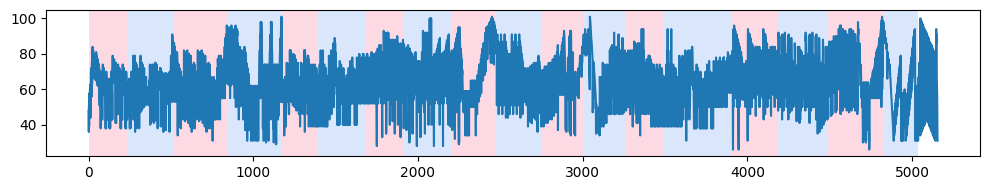

length of seq_from is 242 and of seq_to is 244
length of seq_from is 270 and of seq_to is 288
length of seq_from is 329 and of seq_to is 324
length of seq_from is 332 and of seq_to is 326
length of seq_from is 217 and of seq_to is 219
length of seq_from is 293 and of seq_to is 293
length of seq_from is 235 and of seq_to is 250
length of seq_from is 284 and of seq_to is 304
length of seq_from is 270 and of seq_to is 267
length of seq_from is 283 and of seq_to is 281
length of seq_from is 245 and of seq_to is 241
length of seq_from is 265 and of seq_to is 268
length of seq_from is 231 and of seq_to is 240
length of seq_from is 405 and of seq_to is 399
length of seq_from is 287 and of seq_to is 288
length of seq_from is 304 and of seq_to is 303
length of seq_from is 330 and of seq_to is 344
length of seq_from is 214 and of seq_to is 216


In [ ]:
seq_from, seq_to = segment_and_match(sequences_from[0], sequences_to[0])

In [ ]:
print(seq_from[0][0], seq_to[0][0])

[1, 5646, 48, 82] [1, 1200, 48, 90]


In [ ]:
#clasp = BinaryClaSPSegmentation(validation="score_threshold", threshold=.66)
data_from = []
data_to = []
for i in tqdm(range(0, len(sequences_from))):
    from_temp, to_temp = segment_and_match(sequences_from[i], sequences_to[i], seq_len=250)
    data_from.extend(from_temp)
    data_to.extend(to_temp)


100%|██████████| 329/329 [40:33<00:00,  7.40s/it]


In [ ]:
print("Extracted {x} segments from input seq and matched {y} segments from output seq".format(x=len(data_from), y=len(data_to)))

Extracted 4039 segments from input seq and matched 4039 segments from output seq


In [ ]:
average_from = sum(len(element) for element in data_from) / len(data_from)
average_to = sum(len(element) for element in data_to) / len(data_to)
print("Average length of input seq is {x} and average length of output seq is {y}".format(x=average_from, y=average_to))

Average length of input seq is 359.54964100024756 and average length of output seq is 364.10002475860364


In [ ]:
diff_list = [len(x)-len(y) for x,y in zip(data_from, data_to)]
print("Maximum difference between input and output sequence pair:", max(diff_list), "at position", diff_list.index(max(diff_list)))

Maximum difference between input and output sequence pair: 383 at position 59


In [ ]:

pickle.dump(data_from, open("/content/drive/MyDrive/MusicAI/segment/data/data_from.p", "wb"))
pickle.dump(data_to, open("/content/drive/MyDrive/MusicAI/segment/data/data_to.p", "wb"))


In [ ]:
scs = "success"
pickle.dump(scs, open("/content/drive/MyDrive/MusicAI/segment/data/success.p", "wb"))

In [ ]:
data_from = pickle.load(open("/content/drive/MyDrive/MusicAI/segment/data/data_from.p", "rb"))
data_to = pickle.load(open("/content/drive/MyDrive/MusicAI/segment/data/data_to.p", "rb"))

In [ ]:
data = [(x, y) for x,y in zip(data_from, data_to) if 0.95 < abs(len(x)/len(y)) < 1.05]

In [ ]:
data = [(x, y) for x,y ]

3169